<a href="https://colab.research.google.com/github/FedericoMiscione/LabIA_Prjct/blob/master/BCD_for_DENDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from scipy.ndimage import zoom

!pip install rasterio
import rasterio

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import albumentations as A

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score

Connessione al drive da cui prendere il dataset

In [ ]:
from google.colab import drive, files

drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Check del device disponibile [GPU --> "cuda" || CPU --> "cpu"]
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print("Using PyTorch version: ", torch.__version__, " Device: ", device)

Using PyTorch version:  2.1.0+cu121  Device:  cuda


Definizione dei path e dei filename da cui prendere il dataset e suddividerlo in train, validation  e test set

In [ ]:
DATA_PATH = "/content/gdrive/My Drive/Dataset_progetto"
train_txt = "train.txt"
val_txt = "val.txt"
test_txt = "test.txt"

Implementazione della classe dataset con le opportune modifiche effettuate basandosi sulle osservazioni riguardanti il dataset specifico Dynamic Earth Net

In [ ]:
class DynamicEarthNetDataset(Dataset):

  def __init__(self, root, mode, period, transform, num_classes=7, ignored_classes=[1, 2, 3, 4, 5, 6]):
    super().__init__()

    # Path da cui caricare gli elementi del dataset
    self.root = root

    self.transform = transform

    # mode: "train" or "val" or "test"
    # Utile per la suddivisione del dataset in train_set, validation_set e test_set
    self.train = False
    if mode == "train":
      self.txt_file = train_txt
      self.train = True
    elif mode == "val":
      self.txt_file = val_txt
      self.train = False
    elif mode == "test":
      self.txt_file = test_txt
      self.train = False

    # period: "biannual" or "annual" | "biannual": semestrale => self.period = 6 ; "annual": annuale => self.period = 12
    #                                | di default si sceglie di confrontarla con lo snapshot più recente in ordine temporale (self.period = 22)
    # Utile per selezionare il periodo temporale di confronto tra due immagini della stessa area geografica
    # Ogni considerazione è fatta tenendo conto del numero di mesi a disposizione nel dataset [Osservazioni di 2 anni => 24 mesi]
    if period == "biannual":
      self.period = 6
    elif period == "annual":
      self.period = 12
    else:
      self.period = 22

    self.num_classes = num_classes
    self.ignored_classes = ignored_classes

    # transform function da applicare alle immagini del dataset
    self.transform = transform

    aug_transform_with_label = []

    if self.train == True:
      aug_transform_with_label = [
          A.VerticalFlip(p=0.5),
          A.HorizontalFlip(p=0.5),
          A.Resize(height=384, width=384, always_apply=True),
          A.RandomCrop(height=256, width=256, always_apply=True, p=1.0)
      ]
    elif self.train == False:
      aug_transform_with_label = [
          A.Resize(height=256, width=256, always_apply=True)
      ]

    self.dual_transform_l = A.Compose(aug_transform_with_label, p=1.0, additional_targets={'image2': 'image', 'mask' : 'mask'}, is_check_shapes=False)

    # liste delle immagini e delle relative mask
    self.imgs_list, self.masks_list = self.FilesLoader(self.txt_file)

  # Metodo utile per caricamento dei file dal dataset
  def FilesLoader(self, txt_file):
    with open(os.path.join(self.root, txt_file), 'r') as f:
      files_list = f.read().splitlines()

    imgs_list = []
    masks_list = []
    for idx in range(len(files_list)):
      img_path, mask_path = files_list[idx].split()
      imgs_list.append(img_path)
      masks_list.append(mask_path)

    del files_list
    return imgs_list, masks_list

  def __len__(self):
    return len(self.imgs_list)

  def mean_n_std_calculator(self):
    mean = np.zeros((4,))
    std = np.zeros((4,))

    for filename in self.imgs_list:
      img = rasterio.open(os.path.join(self.root, filename)).read()
      img = img.astype(np.float32)
      mean += np.mean(img, axis=(1, 2))
      std += np.std(img, axis=(1, 2))

    mean /= len(self.imgs_list)
    std /= len(self.imgs_list)

    return mean, std

  def get_mask(self, label):
    mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int64)

    for i in range(self.num_classes):
      if i in self.ignored_classes:
        mask[label[i,:,:] == 255] = -1
      else:
        mask[label[i,:,:] == 255] = i

    return mask

  # Elementi della label tutti 0-1 (if pixel == -1 => pixel = 1)
  def label_mod(self, label):
    for i in range(label.shape[0]):
      for j in range(label.shape[1]):
        if label[i, j] != 0:
          label[i, j] = 1
        else:
          label[i, j] = 0

    return label

  def get_img_place_and_date(self, img_path):
    token_list = img_path.split("/")
    place, date = token_list[-2], token_list[-1]
    if date.endswith(".tif"):
      date = date.removesuffix(".tif")
    del token_list
    return place, date

  def get_year_month(self, date, is_mask=False):
    if is_mask:
      year = date.split("_")[0]
      month = date.split("_")[1]
    else:
      year = date.split("-")[0]
      month = date.split("-")[1]
    return year, month

  def get_mask_place_and_date(self, mask_path):
    token_list = mask_path.split("/")
    place, pos, date = token_list[-5], token_list[-2], token_list[-1]
    if pos in date:
      date = date.replace(pos, "")
    if date.endswith(".tif"):
      date = date.removesuffix(".tif")
    del token_list, pos
    return place, date

  def __getitem__(self, index):

    self.imgs_list = sorted(self.imgs_list)
    self.masks_list = sorted(self.masks_list)

    img = rasterio.open(os.path.join(self.root, self.imgs_list[index])).read()
    label1 = rasterio.open(os.path.join(self.root, "labels", self.masks_list[index])).read()
    mask1 = self.get_mask(label1)

    # Acquisizione seconda immagine per confronto basata sul period settato
    place, date = self.get_img_place_and_date(self.imgs_list[index])
    year, month = self.get_year_month(date)

    padding = 0
    if year == "2019":
       padding = 11

    idx2 = padding + int(month) + self.period - 2

    # Se si ha un immagine con cui confrontare in base al periodo scelto che supera la data 12/2019
    # la si confronta con l'ultima immagine disponibile, ossia del mese di dicembre del 2019.
    if idx2 > 22:
      idx2 = -1
    # Se l'immagine è del 12/2019 la si confronta con una che la precede di self.period mesi
    if year == "2019" and month == "12":
      idx2 = - self.period

    sp_list = []
    for i in range(len(self.imgs_list)):
      if place in self.imgs_list[i] and date not in self.imgs_list[i]:
        sp_list.append(self.imgs_list[i])

    sp_list = sorted(sp_list)
    # idx2 = np.random.randint(0, 22)
    img2 = rasterio.open(os.path.join(self.root, sp_list[idx2])).read()
    _, date2 = self.get_img_place_and_date(sp_list[idx2])
    del sp_list

    # Acquisizione relativa mask per genarazione della label
    place, date_mask1 = self.get_mask_place_and_date(self.masks_list[index])
    year, month = self.get_year_month(date_mask1)

    sp_list = []
    for i in range(len(self.masks_list)):
      if place in self.masks_list[i] and date_mask1 not in self.masks_list[i]:
        sp_list.append(self.masks_list[i])

    sp_list = sorted(sp_list)
    label2 = rasterio.open(os.path.join(self.root, "labels", sp_list[idx2])).read()
    mask2 = self.get_mask(label2)
    del sp_list

    # Genesi della label finale
    label = mask1 - mask2
    label = self.label_mod(label)

    augmented_l = self.dual_transform_l(image=img.transpose(1, 2, 0).astype(np.float32), image2=img2.transpose(1, 2, 0).astype(np.float32), mask=label)
    img = augmented_l['image'].transpose(2, 0, 1)
    img2 = augmented_l['image2'].transpose(2, 0, 1)
    label = augmented_l['mask']

    img = torch.tensor(np.array(img), dtype=torch.float)
    img2 = torch.tensor(np.array(img2), dtype=torch.float)
    label = torch.tensor(np.array(label), dtype=torch.int)

    if self.transform is not None:
      img = self.transform(img)
      img2 = self.transform(img2)

    return img, img2, label

La media e la deviazione standard del train set sono state calcolate in un altro script per ogni banda delle immagini utilizzate nel train set, ossia 4 (RGB + Near-InfraRed) attraverso il metodo definito nella classe DENDataset

```
train_mean, train_std = train_set.mean_n_std_calculator()
```
Risultato:

```
Media train set: [ 666.90438769  903.53697729 1021.31235205 2610.93006829]

Deviazione standard train set: [286.17857641 320.16555736 421.99044997 620.38192794]
```

In [ ]:
transform = transforms.Compose([
    transforms.Normalize((666.90438769, 903.53697729, 1021.31235205, 2610.93006829), (286.17857641, 320.16555736, 421.99044997, 620.38192794))
])

Definizione del train, validation e test set

In [ ]:
train_set = DynamicEarthNetDataset(DATA_PATH, "train", "biannual", transform=transform)
valid_set = DynamicEarthNetDataset(DATA_PATH, "val", "biannual", transform=transform)
test_set = DynamicEarthNetDataset(DATA_PATH, "test", "biannual", transform=transform)

print(f"train_set size = {len(train_set)}, valid_set size = {len(valid_set)}, test_set size = {len(test_set)}")

train_set size = 1080, valid_set size = 120, test_set size = 120


Definizione dei DataLoader del train, validation e test set

In [ ]:
batch_size = 8
num_threads = 2

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=num_threads)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=num_threads)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

----------------------------------------------------------------------------------------------------
### Visualizzazione delle immagini nel dataset

In [ ]:
def multispectral_to_rgb_visualization(img, lower_percentile=5, upper_percentile=95):
    """
    Function for converting a multispectral image to RGB for visualization.
    It clips the top and bottom 5% of the image intensities and then normalizes
    the image to [0, 255] uint8 range.

    Args:
        img: a numpy array of shape (C, H, W) where the first 3 channels are BGR

    Returns:
        img: a numpy array of type uint8 and shape (H, W, 3) representing the RGB image
    """
    assert isinstance(img, np.ndarray), "The input image must be a numpy array"

    img = img.transpose(1,2,0)
    img = img[:, :, [2, 1, 0]]
    img = np.clip(img, np.percentile(img, lower_percentile), np.percentile(img, upper_percentile))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 255).astype(np.uint8)
    return img

def img_converter(img):
  img = img.numpy()
  img = multispectral_to_rgb_visualization(img)
  return img

def img_visualizer():
  dataiter = iter(train_loader)
  img1, img2, label = next(dataiter)
  print(f"{img1.shape}, {img2.shape}, {label.shape}")

  for batch in range(batch_size):

    img_1 = img_converter(img1[batch])
    img_2 = img_converter(img2[batch])
    msk = label[batch].numpy()

    imgs = [img_1, img_2, msk]

    fig, axes = plt.subplots(1, 3, figsize=(9, 9))

    for i, ax in enumerate(axes.flat):
      ax.imshow(imgs[i])
      if i == 2:
        ax.set_title("Label")

      ax.set_axis_off()

    plt.show()
    del imgs

  del dataiter

def img_x_segmentation_visualizer():
  dataiter = iter(train_loader)
  img, mask = next(dataiter)

  imgs = []
  for batch in range(1):
    img_1 = img_converter(img[batch])
    msk = mask[batch].numpy()

    imgs = [img_1, msk]

    fig, axes = plt.subplots(1, 2, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
      ax.imshow(imgs[i])
      ax.set_axis_off()

    plt.show()

  del imgs, dataiter

torch.Size([1, 4, 256, 256]), torch.Size([1, 4, 256, 256]), torch.Size([1, 256, 256])


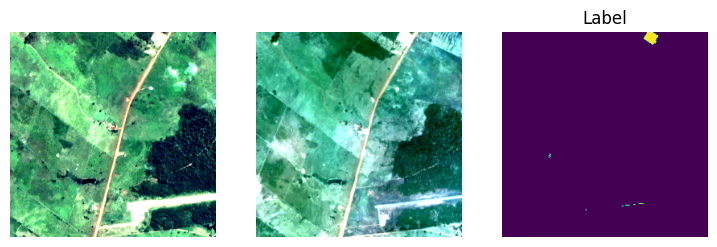

In [ ]:
img_visualizer()

## Calcolo dei weights

Calcolo attraverso il seguente script che utilizza le label generate, che sono delle difference map, la percentuale dei changed pixel rispetto al totale.

```
def pixel_counter(label, total=0, changed=0):
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      total += 1
      if label[i, j] != 0:
        changed += 1
  return total, changed

def weights_calculator():
    total_pixel, changed_pixel = 0, 0
    update_list = []
    for batch in tqdm(train_loader):
      _, _, label = batch

      for idx in range(batch_size):
        total, changed = pixel_counter(label[idx])
        total_pixel += total
        changed_pixel += changed
      change_ratio = changed_pixel / total_pixel
      update_list.append(change_ratio)

    change_ratio = changed_pixel / total_pixel
    return total_pixel, changed_pixel, change_ratio, update_list

total_pxl, changed_pxl, change_ratio, update_list = weights_calculator()
print(f"Pixel = {total_pxl}, Changed pixels = {changed_pxl} -> Change Ratio = {change_ratio}")
```
Con il seguente risultato:
```
100%|██████████| 40/40 [3:48:37<00:00, 342.94s/it]
Pixel = 1132462080, Changed pixels = 6032254 -> Change Ratio = 0.005326671953554507
```

-------------------------------------------------------------------------------------
#Definizione del modello di Rete Neurale

In [ ]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(DoubleConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    return self.conv(x)

class U_Net(nn.Module):
  def __init__(self, in_ch=8, out_ch=2, layers=[32, 64, 128, 256]):
    super(U_Net, self).__init__()
    self.decoders = nn.ModuleList()
    self.encoders = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for layer in layers:
      self.encoders.append(DoubleConvBlock(in_ch, layer))
      in_ch = layer

    for layer in reversed(layers):
      self.decoders.append(nn.ConvTranspose2d(layer*2, layer, kernel_size=2, stride=2))
      self.decoders.append(DoubleConvBlock(layer*2, layer))

    self.bottleneck = DoubleConvBlock(layers[-1], layers[-1]*2)
    self.final_conv = nn.Conv2d(layers[0], out_ch, kernel_size=1)

  def forward(self, x1, x2):
    skip_connections = []

    x = torch.cat((x1, x2), dim=1)

    for encoder in self.encoders:
      x = encoder(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)

    skip_connections = skip_connections[::-1]

    for index in range(0, len(self.decoders), 2):
      x = self.decoders[index](x)
      skip_connection =  skip_connections[index//2]
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.decoders[index+1](concat_skip)
    x = self.final_conv(x)
    return x

In [ ]:
class FC_Siam_Conc(nn.Module):
  def __init__(self, in_ch=4, out_ch=2):
    super(FC_Siam_Conc, self).__init__()

    self.first_conv = nn.Sequential(
        nn.Conv2d(in_ch, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True)
    )

    self.pool = nn.MaxPool2d(kernel_size=2)

    self.cb_1 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True)
    )

    self.cb_2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
    )

    self.cb_3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
    )

    self.tcb_1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)

    self.tcb_2 = nn.Sequential(
        nn.ConvTranspose2d(384, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
      )

    self.tcb_3 = nn.Sequential(
        nn.ConvTranspose2d(192, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
    )

    self.tcb_4 = nn.Sequential(
        nn.ConvTranspose2d(96, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
    )

    self.final_tcb = nn.Sequential(
        nn.ConvTranspose2d(48, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(16, out_ch, kernel_size=3, stride=1, padding=1)
    )

  def single_branch(self, x):
    x1 = self.first_conv(x)
    x2 = self.cb_1(self.pool(x1))
    x3 = self.cb_2(self.pool(x2))
    x4 = self.cb_3(self.pool(x3))
    return x1, x2, x3, x4

  def forward(self, x, y):
    x1, x2, x3, x4 = self.single_branch(x)
    y1, y2, y3, y4 = self.single_branch(y)

    out = self.pool(y4)
    out = self.tcb_1(out)

    out = torch.cat((out, y4, x4), dim=1)
    out = self.tcb_2(out)

    out = torch.cat((out, y3, x3), dim=1)
    out = self.tcb_3(out)

    out = torch.cat((out, y2, x2), dim=1)
    out = self.tcb_4(out)

    out = torch.cat((out, y1, x1), dim=1)
    out = self.final_tcb(out)

    return out

In [ ]:
tot_pixel = 1132462080
changed = 6032254
not_changed = tot_pixel - changed

w_ch = not_changed / tot_pixel
w_nch = changed / tot_pixel

In [ ]:
# model = U_Net().to(device)
model = FC_Siam_Conc().to(device)
# print(model)

In [ ]:
# Calcolo del numero di parametri da addestrare nel modello
params = 0
for param in model.parameters():
  if param.requires_grad:
    params += param.numel()

print(f"Parametri addestrabili: {params}")


UNET
```
Parametri addestrabili: 7764514
```
SIAMESE NET
```
Parametri addestrabili: 1546354
```

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pos_weight = torch.tensor([2*w_nch , 2*w_ch]).unsqueeze(dim=1).unsqueeze(dim=2)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

In [ ]:
def train():
    model.train()
    epoch_loss = []
    all_labels, all_preds = [], []

    for img1, img2, label in tqdm(train_loader):
        img1, img2, label = img1.to(device=device, dtype=torch.float32), img2.to(device=device, dtype=torch.float32), label.unsqueeze(dim=1).to(device, dtype=torch.float32)
        optimizer.zero_grad()
        output = model(img1, img2)
        loss = criterion(output, label.expand_as(output))

        _, preds = torch.max(output, dim=1)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        del img1, img2, label
        epoch_loss.append(loss.item())

    mean_loss = np.array(epoch_loss).mean()
    # Return average training loss for the epoch
    return mean_loss

def validate():
    model.eval()
    all_labels = []
    all_preds = []
    epoch_loss = []
    val_loss = 0
    n_elem = 0

    with torch.no_grad():
      for img1, img2, label in tqdm(valid_loader):
        img1, img2, label = img1.to(device=device, dtype=torch.float32), img2.to(device=device, dtype=torch.float32), label.unsqueeze(dim=1).to(device=device, dtype=torch.float32)

        output = model(img1, img2)

        epoch_loss.append(criterion(output, label.expand_as(output)).item())

        _, preds = torch.max(output, dim=1)

        axes = None
        for batch in range(batch_size):
          _, axes = plt.subplots(1, 4, figsize=(16, 16))
          n_elem += 1
          for i, ax in enumerate(axes.flat):
            if i == 0:
              ax.imshow(img_converter(img1[batch].cpu()))
              ax.set_title("Before")
              ax.set_axis_off()
            elif i == 1:
              ax.imshow(img_converter(img2[batch].cpu()))
              ax.set_title("Then")
              ax.set_axis_off()
            elif i == 2:
              ax.imshow(preds[batch].cpu().int())
              ax.set_title("Preds")
              ax.set_axis_off()
            else:
              ax.imshow(label[batch][0].cpu())
              ax.set_title("Label")
              ax.set_axis_off()

          plt.savefig(f'/content/gdrive/My Drive/Validation_imgs/pic_{n_elem}.png')
          plt.close()

        del axes

        all_labels = np.concatenate((all_labels, label.flatten().cpu().int()))
        all_preds = np.concatenate((all_preds, preds.flatten().cpu().int()))
        del img1, img2, label

    val_loss = np.array(epoch_loss).mean()

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    del all_labels, all_preds

    return val_loss, accuracy, precision, recall, f1

def test():
    model.eval()
    all_labels = []
    all_preds = []
    test_loss = []
    n_elem = 0

    with torch.no_grad():
      for img1, img2, label in tqdm(test_loader):
        img1, img2, label = img1.to(device=device, dtype=torch.float32), img2.to(device=device, dtype=torch.float32), label.unsqueeze(dim=1).to(device=device, dtype=torch.float32)

        output = model(img1, img2)

        test_loss.append(criterion(output, label.expand_as(output)).item())

        _, preds = torch.max(output, dim=1)

        axes = None
        for batch in range(batch_size):
          _, axes = plt.subplots(1, 4, figsize=(16, 16))
          n_elem += 1
          for i, ax in enumerate(axes.flat):
            if i == 0:
              ax.imshow(img_converter(img1[batch].cpu()))
              ax.set_title("Before")
              ax.set_axis_off()
            elif i == 1:
              ax.imshow(img_converter(img2[batch].cpu()))
              ax.set_title("Then")
              ax.set_axis_off()
            elif i == 2:
              ax.imshow(preds[batch].cpu().int())
              ax.set_title("Preds")
              ax.set_axis_off()
            else:
              ax.imshow(label[batch][0].cpu())
              ax.set_title("Label")
              ax.set_axis_off()

          plt.savefig(f'/content/gdrive/My Drive/test_results/pic_{n_elem}.png')
          plt.close()

        del axes

        all_labels = np.concatenate((all_labels, label.flatten().cpu().int()))
        all_preds = np.concatenate((all_preds, preds.flatten().cpu().int()))
        del img1, img2, label

    test_loss = np.array(test_loss).mean()

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    del all_labels, all_preds

    return test_loss, accuracy, precision, recall, f1

In [ ]:
restart_epoch = 0
NUM_EPOCHS = 30

checkpoint_path = f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_SIAMNET_epoch_11.pt'
# checkpoint_path = f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_UNET_epoch_15.pt'

# Carica il checkpoint se esiste
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  restart_epoch = checkpoint['epoch'] + 1 # Riprende dalla prossima epoca
  train_loss = checkpoint['loss']
  val_loss = checkpoint['validation loss']
  accuracy = checkpoint['accuracy']
  precision = checkpoint['precision']
  recall = checkpoint['recall']
  f1 = checkpoint['f1_score']
  print(f"Checkpoint loaded. Resuming training from Epoch {restart_epoch} with:")
  print(f"Train loss = {train_loss:.4f} | Validation loss = {val_loss:.4f}, Accuracy = {100*accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1_score = {f1:.4f}")
else:
  print(f"Checkpoint not found! Training from zero...")

for epoch in range(restart_epoch, NUM_EPOCHS):

  val_loss, accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0, 0.0

  train_loss = train()
  print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}")

  print(f"Saving training stats for epoch {epoch+1}...")
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': train_loss,
      'validation loss': val_loss,
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1_score' : f1
  }
  torch.save(checkpoint, f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_SIAMNET_epoch_{epoch+1}.pt')
  print("Training stats saved!")

  val_loss, accuracy, precision, recall, f1 = validate()
  print(f"Validation: Loss = {val_loss:.4f}, Accuracy = {100*accuracy:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

  # Salvataggio del checkpoint dopo ogni epoca
  print(f"Saving validation stats for epoch {epoch+1}...")
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': train_loss,
      'validation loss': val_loss,
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1_score' : f1
  }
  torch.save(checkpoint, f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_SIAMNET_epoch_{epoch+1}.pt')
  # torch.save(checkpoint, f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_UNET_epoch_{epoch+1}.pt')
  print("Validation stats saved!")

In [ ]:
train_lossv, val_lossv, accv, precv, recv = [], [], [], [], []


for epoch in range(9):
  checkpoint_path = f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/UNET/checkpoint_UNET_epoch_{epoch+1}.pt'

  # Carica il checkpoint se esiste
  if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    train_lossv.append(checkpoint['loss'])
    val_lossv.append(checkpoint['validation loss'])
    accv.append(checkpoint['accuracy'])
    precv.append(checkpoint['precision'])
    recv.append(checkpoint['recall'])
    f1 = checkpoint['f1_score']

## Analisi dei risultati

In [ ]:
def plotter(vect, epochs, metric, title, n_vect=1):
  if n_vect == 1:
    sns.lineplot(x=epochs, y=vect, label=title)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
  elif n_vect > 1:
    for i in range(n_vect):
      sns.lineplot(x=epochs, y=vect[i], label=title[i])
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()

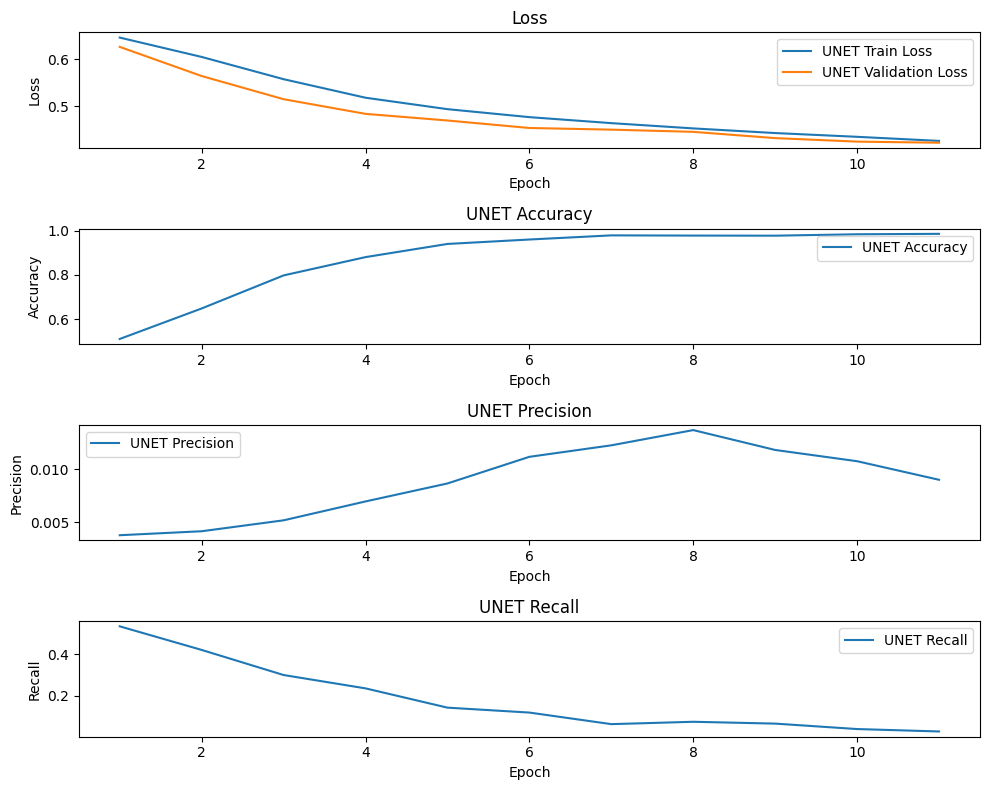

In [ ]:
epochs = np.arange(1, 9)
plt.figure(figsize=(10, 8))
# Loss plot
plt.subplot(4, 1, 1)
plotter([train_lossv, val_lossv], epochs, metric="Loss", title=["UNET Train Loss", "UNET Validation Loss"], n_vect=2)
# Accuracy
plt.subplot(4, 1, 2)
plotter(accv, epochs, metric="Accuracy", title="UNET Accuracy")
# Precision
plt.subplot(4, 1, 3)
plotter(precv, epochs, metric="Precision", title="UNET Precision")
# Recall
plt.subplot(4, 1, 4)
plotter(recv, epochs, metric="Recall", title="UNET Recall")

plt.tight_layout()
plt.show()

**Analisi UNET**

Si può notare come i valori della loss di train e della validation vanno a convergere intorno all'epoch 11 sul valore di 0.42 e l'accuracy sul set di validation tende a stabilizzarsi intorno al 97% (In seguito tende ad oscillare). La precision invece ha un picco di 0.0137 (quindi circa 1% dei TP sono effettivamente rilevati) nell'epoch 8 e in seguito tende a decrescere, mentre la recall decresce con continuità, ciò indica che il numero di TP è molto inferiore al numero di FN. Questi andamenti mi portano ad affermare che in seguito all'epoch 8 il modello tende ad andare in overfitting e smette di generalizzare per la risoluzione del problema.

In [ ]:
siam_train_lossv, siam_val_lossv, siam_accv, siam_precv, siam_rec = [], [], [], [], []
for epoch in range(4):
  checkpoint_path = f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/SIAMNET/checkpoint_SIAMNET_epoch_{epoch+1}.pt'

  # Carica il checkpoint se esiste
  if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    siam_train_lossv.append(checkpoint['loss'])
    siam_val_lossv.append(checkpoint['validation loss'])
    siam_accv.append(checkpoint['accuracy'])
    siam_precv.append(checkpoint['precision'])
    siam_rec.append(checkpoint['recall'])
    f1 = checkpoint['f1_score']

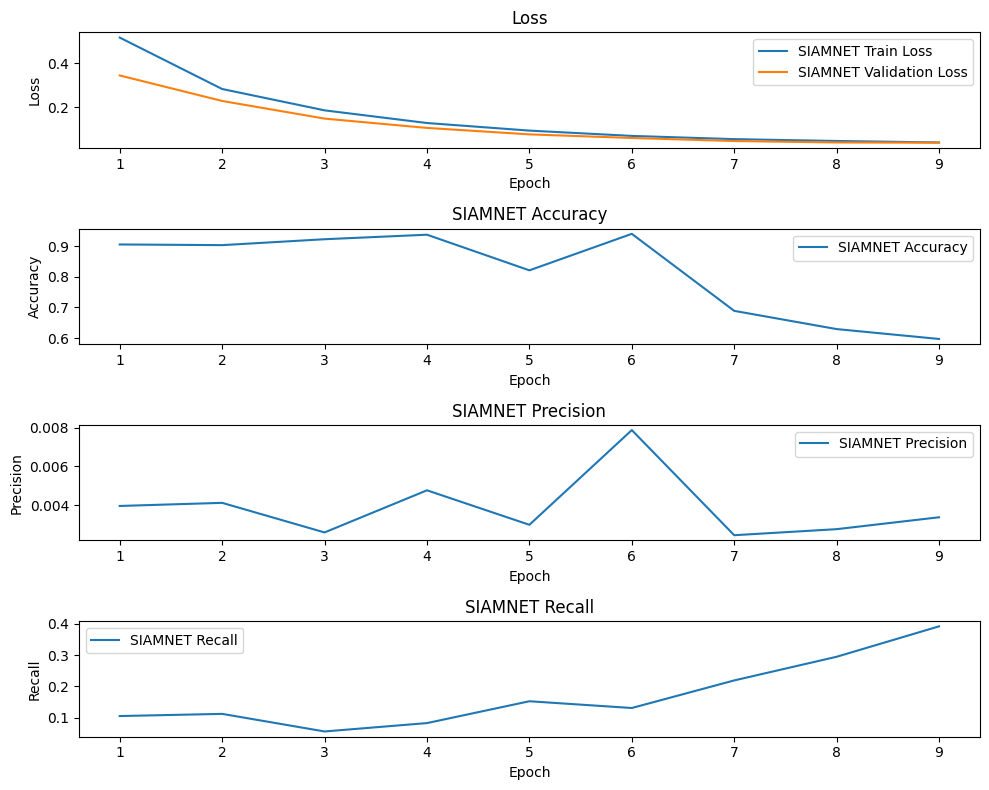

In [ ]:
epochs = np.arange(1, 10)
plt.figure(figsize=(10,8))
# Loss plot
plt.subplot(4, 1, 1)
plotter([siam_train_lossv, siam_val_lossv], epochs, metric="Loss", title=["SIAMNET Train Loss", "SIAMNET Validation Loss"], n_vect=2)
# Accuracy
plt.subplot(4, 1, 2)
plotter(siam_accv, epochs, metric="Accuracy", title="SIAMNET Accuracy")
# Precision
plt.subplot(4, 1, 3)
plotter(siam_precv, epochs, metric="Precision", title="SIAMNET Precision")
# Recall
plt.subplot(4, 1, 4)
plotter(siam_rec, epochs, metric="Recall", title="SIAMNET Recall")

plt.tight_layout()
plt.show()

**Analisi SIAMESE NET**

Si può notare come i valori della loss di train e della validation vanno a convergere intorno all'epoch 8 sul valore di 0.04. A differenza di quanto osservato con il modello UNET, sia l'accuracy che la precision tendono ad oscillare. In particolare l'accuracy tende a rimanere intorno al 90% fino all'epoch 4 [picco = 93%] mentre in seguito l'accuracy scende sotto il 68% e continua a decrescere, ciò indica il modello non sta nè apprendendo nè generalizzando dopo l'epoch 6. Inoltre la precision oscilla e tocca il valore di picco pari a 0.0048 [circa 0.5%], il chè indica che in generale il numero di TP sono pochi e combinati ai valori di recall intorno allo 0.08 significa che il modello ha anche un alto numero di FN rispetto ai TP.

## Test

In [ ]:
checkpoint_path = f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_SIAMNET_epoch_4.pt'

# Carica il checkpoint se esiste
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

siam_test_loss, siam_test_acc, siam_test_prec, siam_test_rec, siam_test_f1 = test()
print(f"Test: ")
print(f"  Loss = {siam_test_loss}")
print(f"  Accuracy = {siam_test_acc}")
print(f"  Precision = {siam_test_prec}")
print(f"  Recall = {siam_test_rec}")
print(f"  F1-score = {siam_test_f1}")

**SIAMESE NET Test results**

```
Test:
  Loss = 0.6161976218223572
  Accuracy = 0.9716017405192058
  Precision = 0.005361905424522832
  Recall = 0.11502487562189055
  F1-score = 0.010246183163819273
```

In [ ]:
checkpoint_path = f'/content/gdrive/My Drive/Colab_Notebooks/checkpoint/checkpoint_UNET_epoch_8.pt'

# Carica il checkpoint se esiste
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

u_test_loss, u_test_acc, u_test_prec, u_test_rec, u_test_f1 = test()
print(f"Test: ")
print(f"  Loss = {u_test_loss}")
print(f"  Accuracy = {u_test_acc}")
print(f"  Precision = {u_test_prec}")
print(f"  Recall = {u_test_rec}")
print(f"  F1-score = {u_test_f1}")

**UNET Test results**

```
Test:
  Loss = 0.7688629110654195
  Accuracy = 0.9019457499186198
  Precision = 0.004781189649518237
  Recall = 0.3655721393034826
  F1-score = 0.009438930836838035
```



---
## Osservazioni

Osservando i risultati ottenuti nella fase di test si possono osservare per entrambi un buon valore di accuracy [Siamese Net -> 97% | U-Net -> 90%] e per la precision [Siamese Net -> 0.53% | U-Net -> 0.47%]. La differenza tra i valori dell'accuracy tra i due modelli sembra essere legato al valore di Falsi Negativi, infatti la recall del modello U-Net è maggiore rispetto a quella del modello Siamese Net [Siamese Net -> 0.1150 | U-Net -> 0.3656].

Osservando inoltre le immagini sembra che la rilevazione dell'evento "change" sia influenzato dai cambiamenti di luminosità e colore legati al canale Near-Infrared.

